In [5]:
#Step 1: Install Required Libraries
#pip install pandas numpy scikit-learn ipywidgets tiktoken sentencepiece
#,(model)pip install xgboost tensorflow keras pip install transformers pythainlp torch 

#Step 2: Import Libraries
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

#PredictionRiskModels 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [26]:
#Step 3: Load dataset (หามาโลด ดูตารางค่าที่รับให้ตรง)
#age, weight, height, blood_sugar, a1c, systolic_bp, diastolic_bp, mood, gender, and target

df = pd.read_csv('diabetes_prediction_dataset.csv')  

In [27]:
#Step 4: Explore the Data (To know structure)
# Display the first few rows of the dataset
print(df.head())

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


In [28]:
#Step 4: Explore the Data (To know structure)
# Get summary statistics
print(df.describe())

                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%        43.000000       0.00000       0.000000      27.320000   
75%        60.000000       0.00000       0.000000      29.580000   
max        80.000000       1.00000       1.000000      95.690000   

         HbA1c_level  blood_glucose_level       diabetes  
count  100000.000000        100000.000000  100000.000000  
mean        5.527507           138.058060       0.085000  
std         1.070672            40.708136       0.278883  
min         3.500000            80.000000       0.000000  
25%         4.800000           100.000000       0.000000  
50%         5.800000           14

In [29]:
#Step 4: Explore the Data (To know structure)
# Check for missing values
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [30]:
#Step 5: Data Preprocessing
#(1)Delete smoking_history Column (Don't use)
df = df.drop(columns=['smoking_history'])

In [31]:
#Step 5: Data Preprocessing
#(2)Create Systolic & Diastolic Column (We need )
def generate_bp(row):
    age = row['age']
    has_hypertension = row['hypertension']
    has_heart_disease = row['heart_disease']

    # ค่าปกติสำหรับอายุแต่ละช่วง
    if age < 30:
        systolic = np.random.randint(100, 120)
        diastolic = np.random.randint(60, 80)
    elif 30 <= age < 50:
        systolic = np.random.randint(110, 130)
        diastolic = np.random.randint(70, 85)
    else:
        systolic = np.random.randint(120, 140)
        diastolic = np.random.randint(75, 90)

    # ถ้ามีความดันสูง เพิ่มค่าความดัน
    if has_hypertension == 1:
        systolic += np.random.randint(10, 20)
        diastolic += np.random.randint(5, 10)

    # ถ้ามีโรคหัวใจ ค่าความดันอาจผิดปกติได้
    if has_heart_disease == 1:
        systolic += np.random.randint(5, 15)
        diastolic += np.random.randint(3, 8)

    return pd.Series([systolic, diastolic])

# ใช้ฟังก์ชันเติมค่าความดัน
df[['systolic_bp', 'diastolic_bp']] = df.apply(generate_bp, axis=1)


In [32]:
#Step 5: Data Preprocessing
#(3)Separate Between Numeric and Categorical Column 

numeric_cols = ['age', 'hypertension','heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes', 'systolic_bp', 'diastolic_bp']
categorical_cols = ['gender',]


#(4)
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

In [33]:
#Step 5: Data Preprocessing
#(5)To Save on New File After Preprocessing
df.to_csv('cleaned_diabetes_prediction_dataset.csv', index=False)

#(6)Check After Preprocessing 
print(df.head())

   gender   age  hypertension  heart_disease    bmi  HbA1c_level  \
0     1.0  80.0             0              1  25.19          6.6   
1     1.0  54.0             0              0  27.32          6.6   
2     0.0  28.0             0              0  27.32          5.7   
3     1.0  36.0             0              0  23.45          5.0   
4     0.0  76.0             1              1  20.14          4.8   

   blood_glucose_level  diabetes  systolic_bp  diastolic_bp  
0                  140         0          139            84  
1                   80         0          136            75  
2                  158         0          117            60  
3                  155         0          115            78  
4                  155         0          163            88  


In [34]:
#Step 5: Data Preprocessing
#(7)Features (X) และ diabetes (y)
# Split data into training and testing sets (80-20 split)
X = df.drop(columns=['diabetes'])
y = df['diabetes']

#80_20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
#Step 5: Data Preprocessing
scaler = StandardScaler()

# Normalize For Same Scale
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

✅ Random Forest - Accuracy: 97.21%, F1-score: 0.97


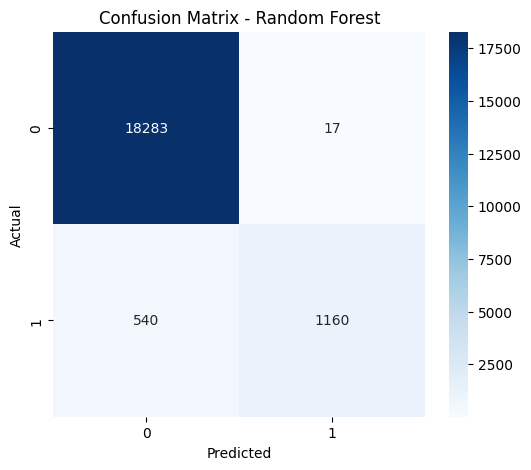


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.99      0.68      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000



In [ ]:
#Step 6: Model Training
#Random Forest Model

rf_model = RandomForestClassifier(
    n_estimators=300,       # จำนวนต้นไม้ในป่า 
    max_depth=None,         # ความลึกของต้นไม้ 
    min_samples_split=10,   # จำนวนขั้นต่ำของตัวอย่างที่ต้องมีเพื่อแบ่ง node ใหม่ 
    random_state=42,        # ตั้งค่า random เพื่อให้ผลลัพธ์คงที่
    n_jobs=-1               # ใช้ทุก CPU Core เพื่อให้เทรนเร็วขึ้น
)

# Train
rf_model.fit(X_train_scaled, y_train)

# Test
rf_pred = rf_model.predict(X_test_scaled)

# Find Accuracy
rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = classification_report(y_test, rf_pred, output_dict=True)['weighted avg']['f1-score']


#Step 7: Show Result
#Random Forest Model
# Show Result
print(f"✅ Random Forest - Accuracy: {rf_acc*100:.2f}%, F1-score: {rf_f1:.2f}")

# Show Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Show Classification Report
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))


✅ XGBoost - Accuracy: 97.19%, F1-score: 0.97


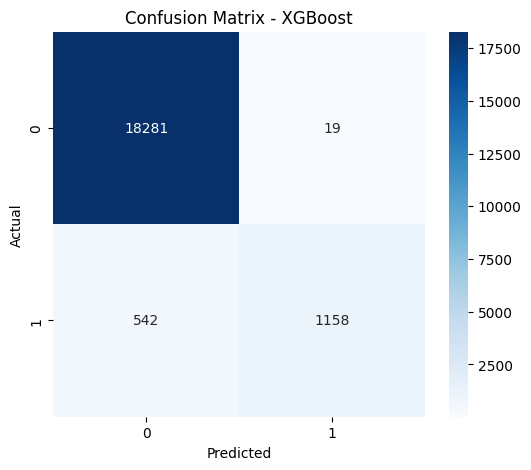


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.98      0.68      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



In [ ]:
#XGBoost Model
xgb_model = XGBClassifier(
    n_estimators=300,   # จำนวนต้นไม้ในป่า 
    learning_rate=0.01,  # อัตราการเรียนรู้
    max_depth=9,        # ความลึกของต้นไม้ 
    eval_metric='logloss',
    random_state=42
)

# Train
xgb_model.fit(X_train_scaled, y_train)

# Predict
xgb_pred = xgb_model.predict(X_test_scaled)

# Find Accuracy
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_f1 = classification_report(y_test, xgb_pred, output_dict=True)['weighted avg']['f1-score']


#Step 7: Show Result
# Show Accuracy
print(f"✅ XGBoost - Accuracy: {xgb_acc*100:.2f}%, F1-score: {xgb_f1:.2f}")

# Show Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Show Classification Report
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred))

Random Forest Train Accuracy: 97.89%
Random Forest Test Accuracy: 97.21%
XGBoost Train Log Loss: 0.0853
XGBoost Test Log Loss: 0.0877


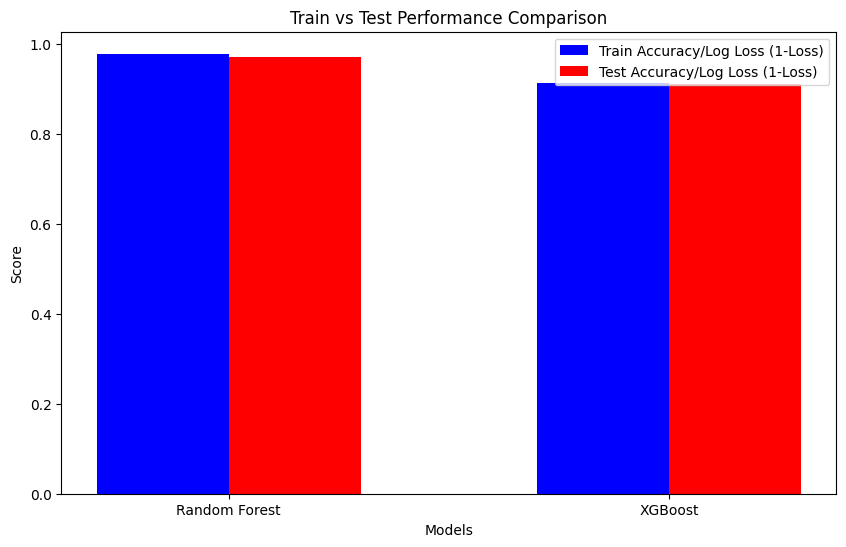

In [43]:
from sklearn.metrics import log_loss

# 1. Random Forest (ใช้ accuracy เพื่อเปรียบเทียบ)
rf_train_pred = rf_model.predict(X_train_scaled)
rf_test_pred = rf_model.predict(X_test_scaled)

rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

print(f"Random Forest Train Accuracy: {rf_train_acc*100:.2f}%")
print(f"Random Forest Test Accuracy: {rf_test_acc*100:.2f}%")

# 2. XGBoost (คำนวณ Log Loss)
xgb_train_pred_prob = xgb_model.predict_proba(X_train_scaled)[:, 1]  # คำนวณ probability
xgb_test_pred_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

xgb_train_loss = log_loss(y_train, xgb_train_pred_prob)
xgb_test_loss = log_loss(y_test, xgb_test_pred_prob)

print(f"XGBoost Train Log Loss: {xgb_train_loss:.4f}")
print(f"XGBoost Test Log Loss: {xgb_test_loss:.4f}")


import matplotlib.pyplot as plt

# Train and Test Accuracy for Random Forest
rf_train_acc = accuracy_score(y_train, rf_model.predict(X_train_scaled))
rf_test_acc = accuracy_score(y_test, rf_model.predict(X_test_scaled))

# Train and Test Log Loss for XGBoost
xgb_train_loss = log_loss(y_train, xgb_model.predict_proba(X_train_scaled)[:, 1])
xgb_test_loss = log_loss(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])

# Plotting the results
models = ['Random Forest', 'XGBoost']
train_scores = [rf_train_acc, 1 - xgb_train_loss]  # 1 - Log Loss is a rough proxy for accuracy
test_scores = [rf_test_acc, 1 - xgb_test_loss]

plt.figure(figsize=(10, 6))
bar_width = 0.3
index = np.arange(len(models))

# Plotting Train Scores
plt.bar(index, train_scores, bar_width, label='Train Accuracy/Log Loss (1-Loss)', color='b')

# Plotting Test Scores
plt.bar(index + bar_width, test_scores, bar_width, label='Test Accuracy/Log Loss (1-Loss)', color='r')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Train vs Test Performance Comparison')
plt.xticks(index + bar_width / 2, models)
plt.legend()

plt.show()


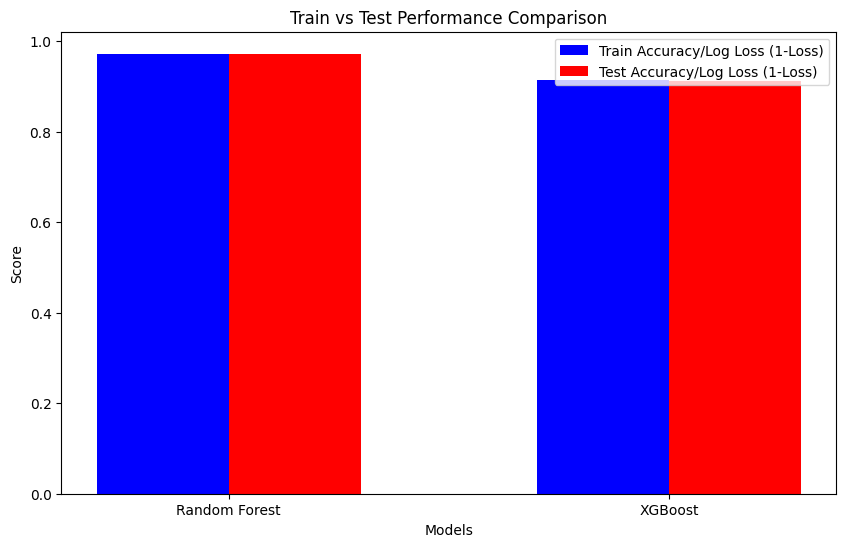

In [44]:
import matplotlib.pyplot as plt

# Data
models = ['Random Forest', 'XGBoost']
train_scores = [rf_acc, 1 - xgb_train_loss]  # 1 - Log Loss as rough accuracy
test_scores = [rf_test_acc, 1 - xgb_test_loss]

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.3
index = np.arange(len(models))

plt.bar(index, train_scores, bar_width, label='Train Accuracy/Log Loss (1-Loss)', color='b')
plt.bar(index + bar_width, test_scores, bar_width, label='Test Accuracy/Log Loss (1-Loss)', color='r')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Train vs Test Performance Comparison')
plt.xticks(index + bar_width / 2, models)
plt.legend()

plt.show()


In [ ]:
from sklearn.ensemble import VotingClassifier

# Combine Random Forest and XGBoost into a voting classifier (จุดแข็งของทั้ง 2)
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model), 
    ('xgb', xgb_model)], voting='soft')

# Train the voting classifier
voting_clf.fit(X_train_scaled, y_train)

# Evaluate the performance of the voting classifier
voting_pred = voting_clf.predict(X_test_scaled)
voting_acc = accuracy_score(y_test, voting_pred)
voting_f1 = classification_report(y_test, voting_pred, output_dict=True)['weighted avg']['f1-score']

print(f"Voting Classifier - Accuracy: {voting_acc*100:.2f}%, F1-score: {voting_f1:.2f}")


Voting Classifier - Accuracy: 97.20%, F1-score: 0.97


In [ ]:
#  ตัวอย่างข้อมูล Input ของผู้ใช้ 5 คน
user_data = [
    {'gender': 'Male', 'weight': 70, 'height': 175, 'blood_sugar': 150, 'A1C': 6.0, 'systolic_bp': 130, 'diastolic_bp': 85, 'mood': 2},
    {'gender': 'Female', 'weight': 65, 'height': 160, 'blood_sugar': 180, 'A1C': 6.5, 'systolic_bp': 140, 'diastolic_bp': 90, 'mood': 6},
    {'gender': 'Male', 'weight': 85, 'height': 180, 'blood_sugar': 120, 'A1C': 5.8, 'systolic_bp': 125, 'diastolic_bp': 80, 'mood': 3},
    {'gender': 'Female', 'weight': 50, 'height': 155, 'blood_sugar': 100, 'A1C': 5.4, 'systolic_bp': 115, 'diastolic_bp': 75, 'mood': 1},
    {'gender': 'Male', 'weight': 90, 'height': 170, 'blood_sugar': 200, 'A1C': 7.5, 'systolic_bp': 150, 'diastolic_bp': 95, 'mood': 5}
]

# ฟังก์ชันในการคำนวณคะแนนสุขภาพและความเสี่ยงเบาหวาน
def calculate_health_score(user):
    # คำนวณคะแนนสุขภาพจากข้อมูลต่างๆ
    health_score = 10
    diabetes_risk = "ต่ำมาก"
    health_status = ""
    
    # ความเสี่ยงจากระดับน้ำตาลในเลือด
    if user['blood_sugar'] > 180:
        health_score -= 3
        diabetes_risk = "สูง"
    elif user['blood_sugar'] > 120:
        health_score -= 2
        diabetes_risk = "ปานกลาง"
    
    # ค่าน้ำตาลเฉลี่ยสะสม (A1C)
    if user['A1C'] > 6.5:
        health_score -= 3
        health_status += "ระดับ A1C ไม่ดี ต้องควบคุม"
    elif user['A1C'] > 5.7:
        health_score -= 1
        health_status += "ระดับ A1C ค่อนข้างดี"
    
    # ค่าความดันโลหิต
    if user['systolic_bp'] > 140 or user['diastolic_bp'] > 90:
        health_score -= 2
        health_status += "ความดันโลหิตสูง ควรควบคุม"

    # ค่า BMI (น้ำหนัก/ส่วนสูง)
    bmi = user['weight'] / (user['height'] / 100) ** 2
    if bmi < 18.5:
        health_score -= 1
        health_status += "น้ำหนักต่ำกว่ามาตรฐาน"
    elif bmi > 24.9:
        health_score -= 2
        health_status += "น้ำหนักเกินมาตรฐาน"

    # คำแนะนำตามอารมณ์
    mood_advice = ""
    if user['mood'] in [5, 6, 7]:  # อารมณ์เศร้า, ป่วย, หงุดหงิด
        mood_advice = "อารมณ์ไม่ดี ควรพักผ่อนและดูแลจิตใจ"
    elif user['mood'] in [1, 2, 3]:  # อารมณ์ดี
        mood_advice = "สุขภาพจิตดี ควรออกกำลังกายเพื่อสุขภาพที่ดีขึ้น"

    # Return Health Recommendations
    return health_score, diabetes_risk, health_status, mood_advice

# ฟังก์ชันเพื่อคำแนะนำในการดูแลสุขภาพ
def health_advice(user):
    # คำแนะนำการออกกำลังกาย
    exercise = "ออกกำลังกาย 30 นาทีต่อวัน เช่น เดินเร็ว หรือ วิ่ง"
    
    # คำแนะนำอาหาร
    food = "ทานอาหารที่มีไฟเบอร์สูง เช่น ผักใบเขียว, ข้าวกล้อง, ปลาแซลมอน"
    
    # บทความที่แนะนำ
    article = "บทความเกี่ยวกับการควบคุมระดับน้ำตาลในเลือด"
    
    # คำพูดสร้างแรงบันดาลใจ
    motivation = "คุณทำได้! ทุกการเปลี่ยนแปลงเล็กๆ นำไปสู่ผลลัพธ์ที่ดีขึ้น"
    
    return exercise, food, article, motivation

# Step 2: คำนวณผลลัพธ์จากข้อมูล 5 คน
for i, user in enumerate(user_data, 1):
    print(f"User {i}:")
    
    # คำนวณคะแนนสุขภาพและความเสี่ยงเบาหวาน
    health_score, diabetes_risk, health_status, mood_advice = calculate_health_score(user)
    
    # คำแนะนำในการดูแลสุขภาพ
    exercise, food, article, motivation = health_advice(user)
    
    # แสดงผลลัพธ์
    print(f"Health Score: {health_score}/10")
    print(f"Diabetes Risk: {diabetes_risk}")
    print(f"Health Status: {health_status}")
    print(f"Mood Advice: {mood_advice}")
    print(f"Exercise Recommendation: {exercise}")
    print(f"Food Recommendation: {food}")
    print(f"Article Recommendation: {article}")
    print(f"Motivational Advice: {motivation}")
    print("\n" + "="*40 + "\n")


User 1:
Health Score: 7/10
Diabetes Risk: ปานกลาง
Health Status: ระดับ A1C ค่อนข้างดี
Mood Advice: สุขภาพจิตดี ควรออกกำลังกายเพื่อสุขภาพที่ดีขึ้น
Exercise Recommendation: ออกกำลังกาย 30 นาทีต่อวัน เช่น เดินเร็ว หรือ วิ่ง
Food Recommendation: ทานอาหารที่มีไฟเบอร์สูง เช่น ผักใบเขียว, ข้าวกล้อง, ปลาแซลมอน
Article Recommendation: บทความเกี่ยวกับการควบคุมระดับน้ำตาลในเลือด
Motivational Advice: คุณทำได้! ทุกการเปลี่ยนแปลงเล็กๆ นำไปสู่ผลลัพธ์ที่ดีขึ้น


User 2:
Health Score: 5/10
Diabetes Risk: ปานกลาง
Health Status: ระดับ A1C ค่อนข้างดีน้ำหนักเกินมาตรฐาน
Mood Advice: อารมณ์ไม่ดี ควรพักผ่อนและดูแลจิตใจ
Exercise Recommendation: ออกกำลังกาย 30 นาทีต่อวัน เช่น เดินเร็ว หรือ วิ่ง
Food Recommendation: ทานอาหารที่มีไฟเบอร์สูง เช่น ผักใบเขียว, ข้าวกล้อง, ปลาแซลมอน
Article Recommendation: บทความเกี่ยวกับการควบคุมระดับน้ำตาลในเลือด
Motivational Advice: คุณทำได้! ทุกการเปลี่ยนแปลงเล็กๆ นำไปสู่ผลลัพธ์ที่ดีขึ้น


User 3:
Health Score: 7/10
Diabetes Risk: ต่ำมาก
Health Status: ระดับ A1C ค่อนข้างดีน้ำหนักเ